Predicting customer churn with decision tree, random forest and xgboost

In [1]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn 

%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [2]:
raw_data = pd.read_csv('raw_data.csv')
print(raw_data.shape)
raw_data.head(5)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
for column in raw_data:
    unique_values = np.unique(raw_data[column])
    no_values = len(unique_values)
    if no_values < 36:
        print("LESS, The number of values for feature {}: {} -- {}".format(column, no_values, unique_values))
    else:
        print("MORE, The number of values for feature {}: {}".format(column, no_values))

MORE, The number of values for feature RowNumber: 10000
MORE, The number of values for feature CustomerId: 10000
MORE, The number of values for feature Surname: 2932
MORE, The number of values for feature CreditScore: 460
LESS, The number of values for feature Geography: 3 -- ['France' 'Germany' 'Spain']
LESS, The number of values for feature Gender: 2 -- ['Female' 'Male']
MORE, The number of values for feature Age: 70
LESS, The number of values for feature Tenure: 11 -- [ 0  1  2  3  4  5  6  7  8  9 10]
MORE, The number of values for feature Balance: 6382
LESS, The number of values for feature NumOfProducts: 4 -- [1 2 3 4]
LESS, The number of values for feature HasCrCard: 2 -- [0 1]
LESS, The number of values for feature IsActiveMember: 2 -- [0 1]
MORE, The number of values for feature EstimatedSalary: 9999
LESS, The number of values for feature Exited: 2 -- [0 1]


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
raw_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

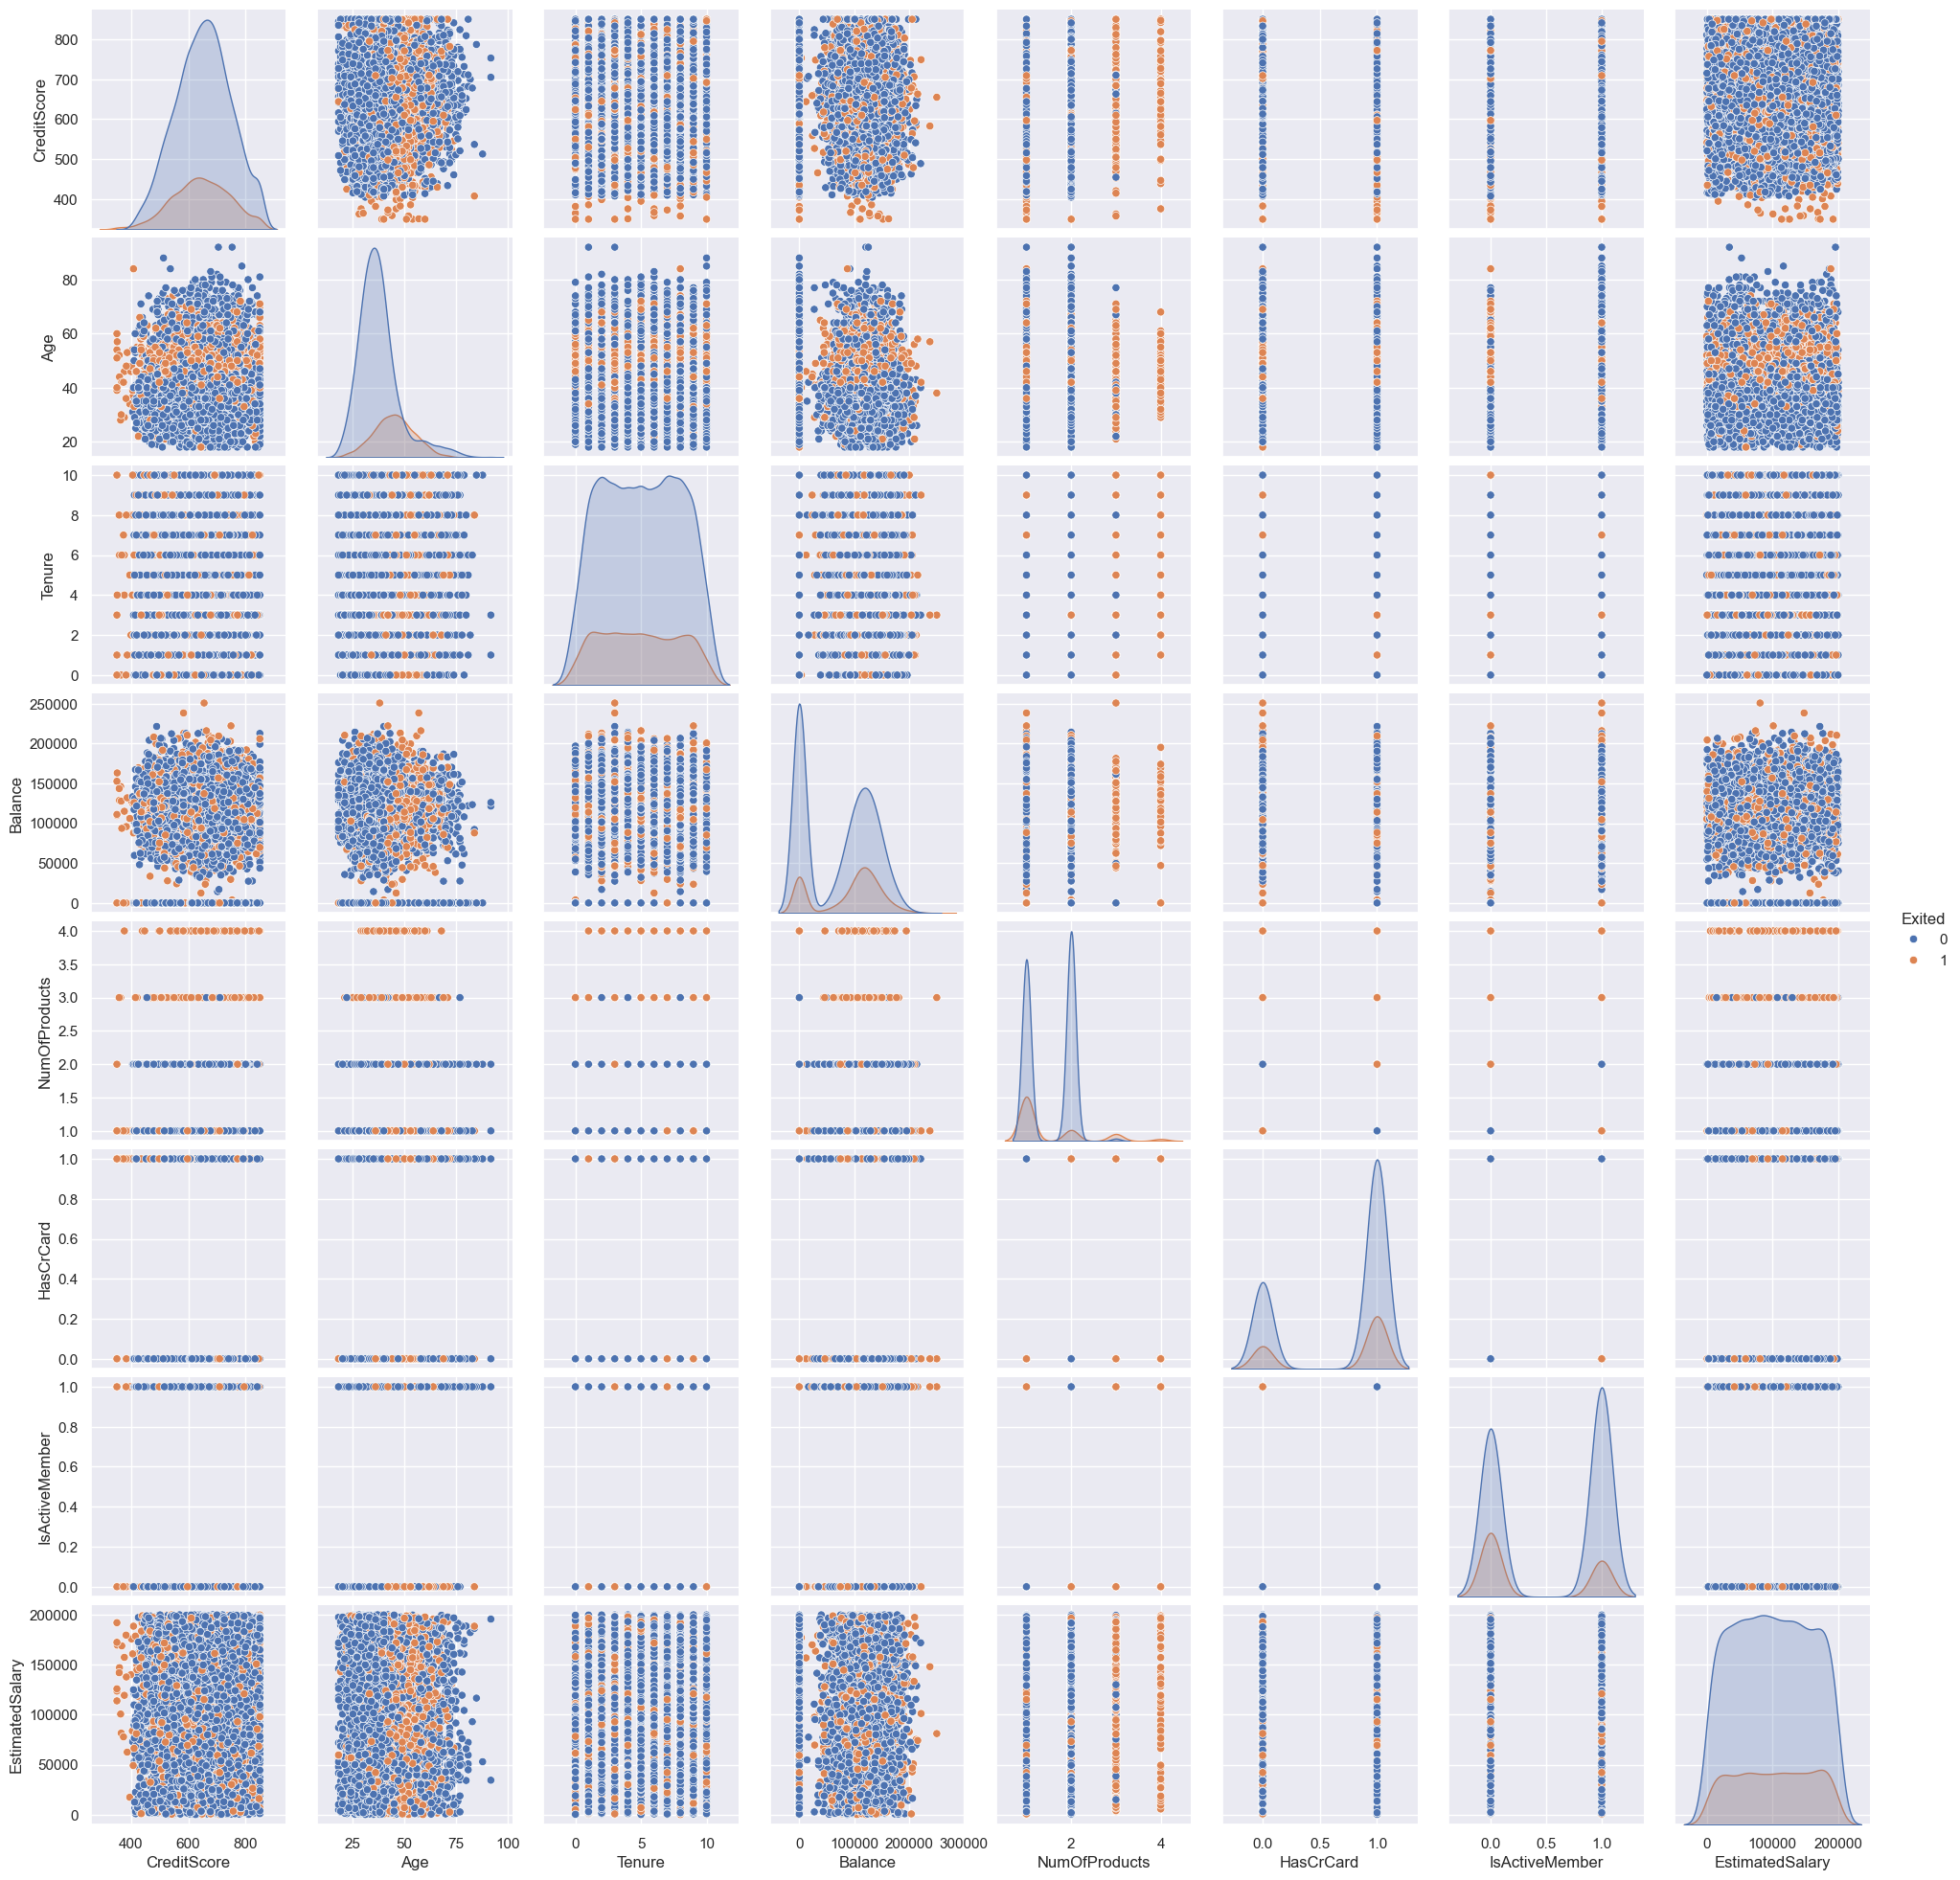

In [6]:
limited_raw_data = raw_data[["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]]

g = sns.pairplot(limited_raw_data, hue="Exited", diag_kws= { 'bw': 0.2 })

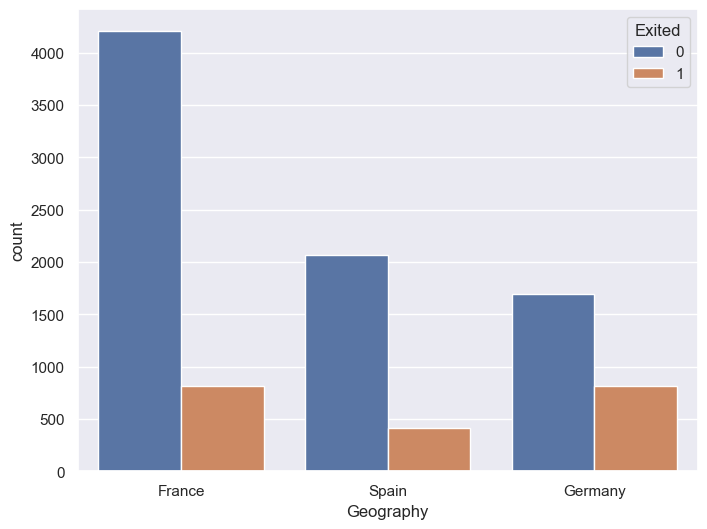

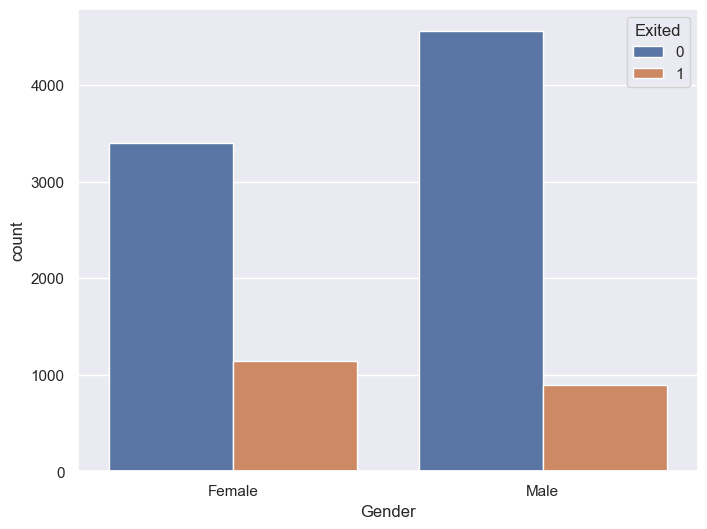

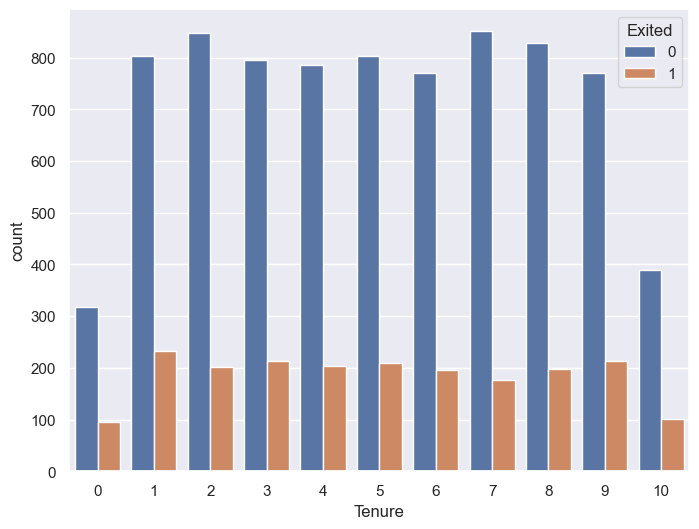

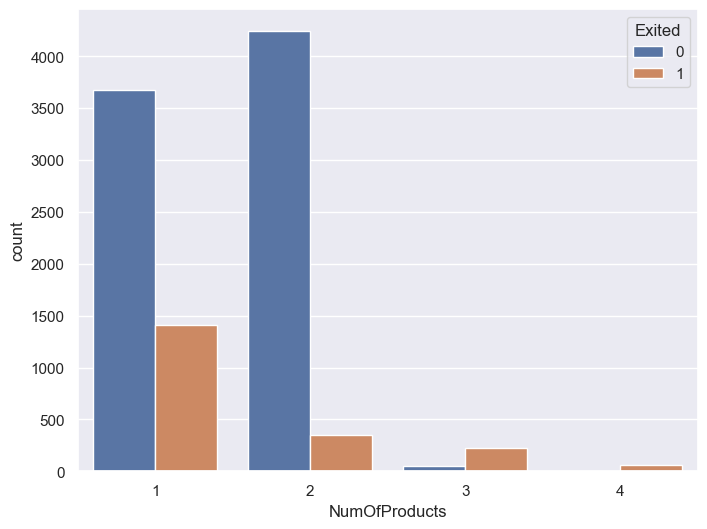

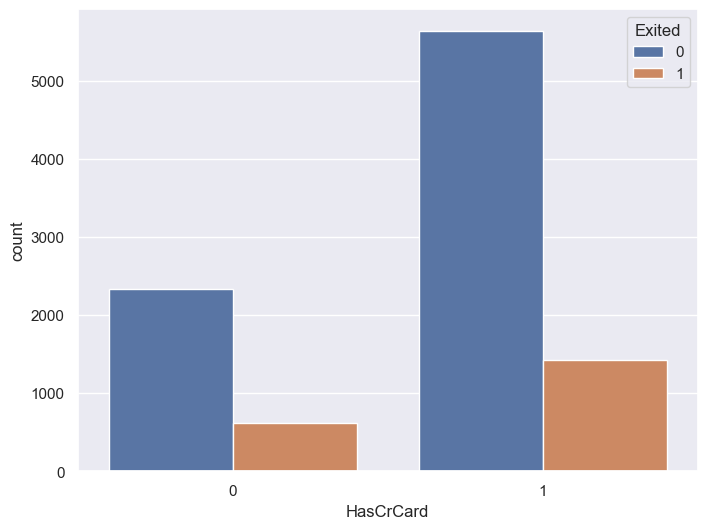

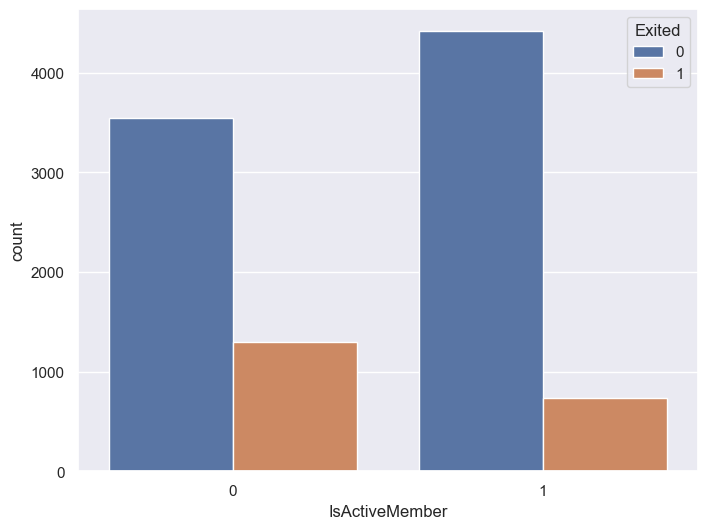

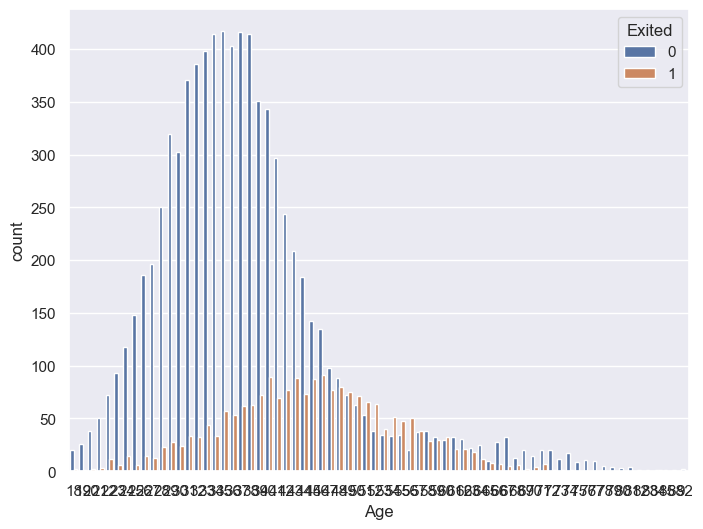

In [7]:
features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age']

for f in features:
    plt.figure()
    sns.countplot(x=f, hue='Exited', data=limited_raw_data)

In [8]:
limited_raw_data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
new_raw_data = pd.get_dummies(limited_raw_data, columns = ['Geography','Gender', 'HasCrCard', 'IsActiveMember'])
new_raw_data.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,True,False,False,True,False,False,True,False,True
1,608,41,1,83807.86,1,112542.58,0,False,False,True,True,False,True,False,False,True
2,502,42,8,159660.80,3,113931.57,1,True,False,False,True,False,False,True,True,False
3,699,39,1,0.00,2,93826.63,0,True,False,False,True,False,True,False,True,False
4,850,43,2,125510.82,1,79084.10,0,False,False,True,True,False,False,True,False,True


In [10]:
# scaling

scale_vars = ['CreditScore', 'EstimatedSalary', 'Balance', 'Age']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,True,False,False,True,False,False,True,False,True
1,0.516,0.310811,1,0.334031,1,0.562709,0,False,False,True,True,False,True,False,False,True
2,0.304,0.324324,8,0.636357,3,0.569654,1,True,False,False,True,False,False,True,True,False
3,0.698,0.283784,1,0.000000,2,0.469120,0,True,False,False,True,False,True,False,True,False
4,1.000,0.337838,2,0.500246,1,0.395400,0,False,False,True,True,False,False,True,False,True


In [11]:
# splitting data

X = new_raw_data.drop('Exited', axis=1).values
y = new_raw_data['Exited'].values
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=42)

X shape: (10000, 15)
y shape: (10000,)


In [12]:
# Decision Tree model



dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state = 1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

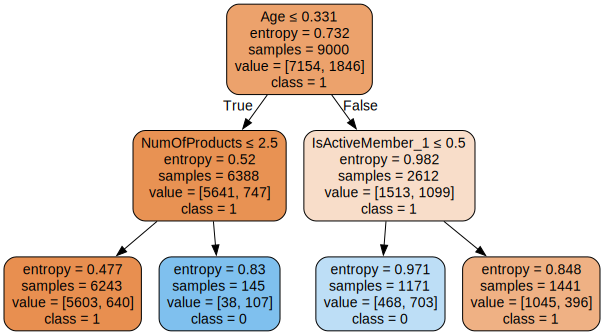

In [13]:
import graphviz 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_raw_data.drop('Exited', axis=1).columns,    
    class_names=new_raw_data['Exited'].unique().astype(str),  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [14]:
# confirming the decision tree by checking the feature importance

for i, column in enumerate(new_raw_data.drop('Exited', axis = 1)):
    print('Importance of feature: {}'.format(column, dt.feature_importances_[i]))

    fi = pd.DataFrame({ 'Variable' : [column] , 'Feauture Importance Score' : [dt.feature_importances_[i]]})

    try:
        fi_data_frame = pd.concat([fi_data_frame, fi], ignore_index = True)

    except:
        fi_data_frame = fi

final_data_frame = fi_data_frame.sort_values('Feauture Importance Score', ascending=False).reset_index()
final_data_frame

Importance of feature: CreditScore
Importance of feature: Age
Importance of feature: Tenure
Importance of feature: Balance
Importance of feature: NumOfProducts
Importance of feature: EstimatedSalary
Importance of feature: Geography_France
Importance of feature: Geography_Germany
Importance of feature: Geography_Spain
Importance of feature: Gender_Female
Importance of feature: Gender_Male
Importance of feature: HasCrCard_0
Importance of feature: HasCrCard_1
Importance of feature: IsActiveMember_0
Importance of feature: IsActiveMember_1


,index,Variable,Feauture Importance Score
0,1,Age,0.617711
1,4,NumOfProducts,0.200802
2,14,IsActiveMember_1,0.181487
3,2,Tenure,0.000000
4,3,Balance,0.000000
5,5,EstimatedSalary,0.000000
6,0,CreditScore,0.000000
7,6,Geography_France,0.000000
8,7,Geography_Germany,0.000000
9,9,Gender_Female,0.000000


In [15]:
print("Training Accuracy is: ", dt.score(X_train, y_train))

# Accuracy on Train
print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is:  0.8286666666666667
Testing Accuracy is:  0.836


In [16]:
y_pred = dt.predict(X_train)

In [17]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

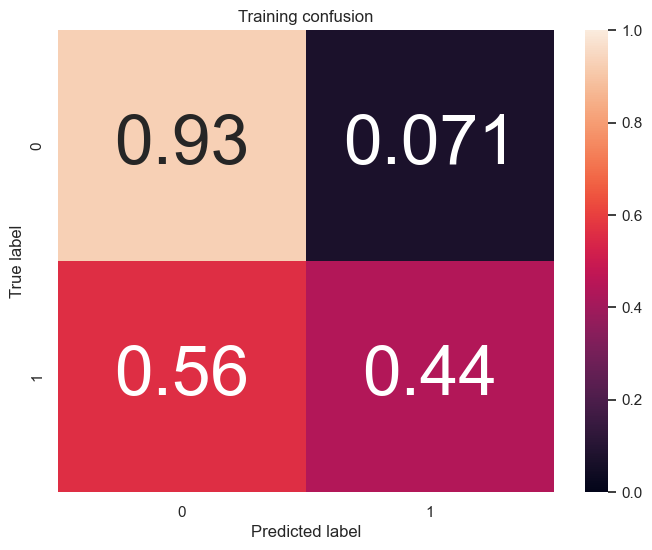

In [18]:
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [19]:
cm

array([[6648,  506],
       [1036,  810]])

In [20]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)


The True Positive rate / Recall per class is:  [0.929270 0.438787]
The Precision per class is:  [0.865174 0.615502]
The False Alarm rate per class is:  [0.561213 0.070730]
The Miss Rate rate per class is:  [0.070730 0.561213]
The Classification error of each class is [0.171333 0.171333]
The Accuracy of each class is [0.828667 0.828667]

The average Recall is:  0.6840284519097121
The average Precision is:  0.7403379540481227
The average False Alarm is:  0.31597154809028793
The average Miss Rate rate is:  0.31597154809028793
The average Classification error is 0.17133333333333334
The average Accuracy is 0.8286666666666667


 Accuracy on Training is:  1.0
 Accuracy on Testing is:  0.87


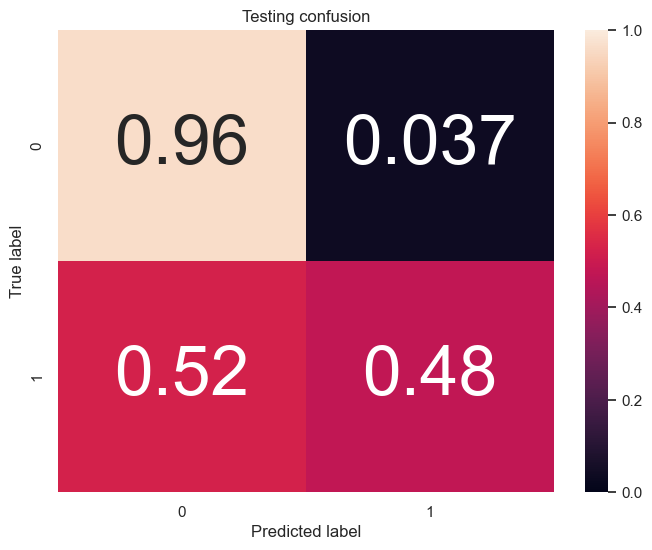

In [21]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=1)
rf.fit(X_train, y_train)
prediction_test = rf.predict(X = X_test)
 
# accuracy on train
print(" Accuracy on Training is: ", rf.score(X_train, y_train))
# accuracy on test 
print(" Accuracy on Testing is: ", rf.score(X_test, y_test))

cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Testing confusion')

Classification accuracy on test set with max features = 1 and max_depth = None: 0.871
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.809
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.809
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.811
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.818
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.867
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.816
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.832
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.847
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.852
Classification accuracy on test set with max features = log2 and max_depth = None: 0.867
Classification accuracy on test set with max features = log2

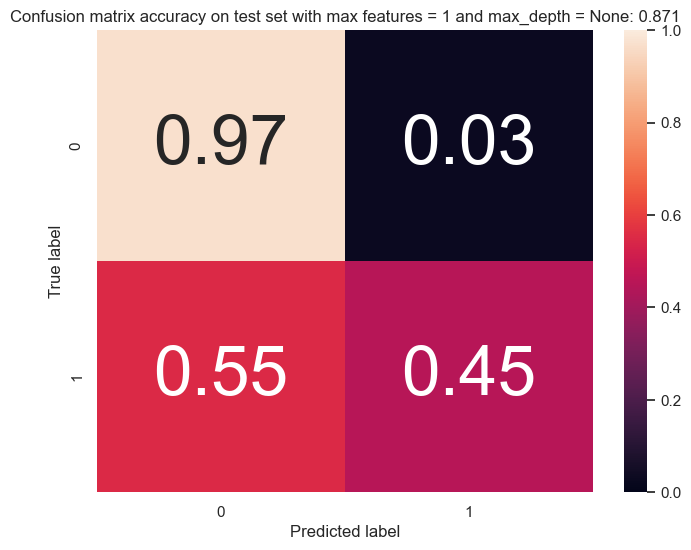

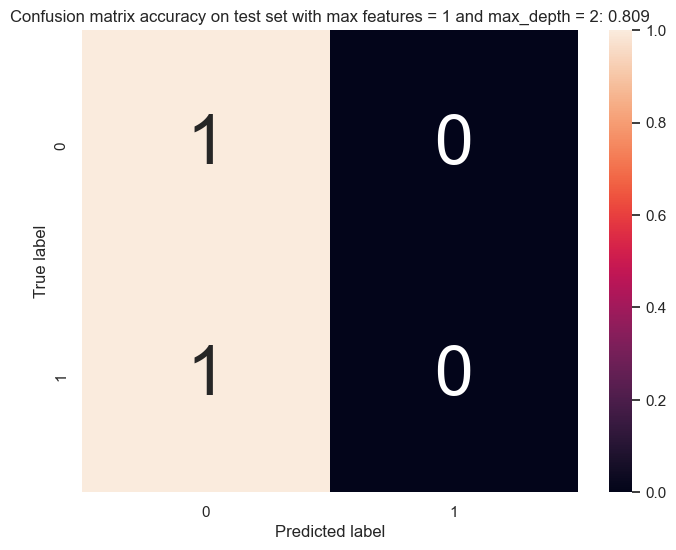

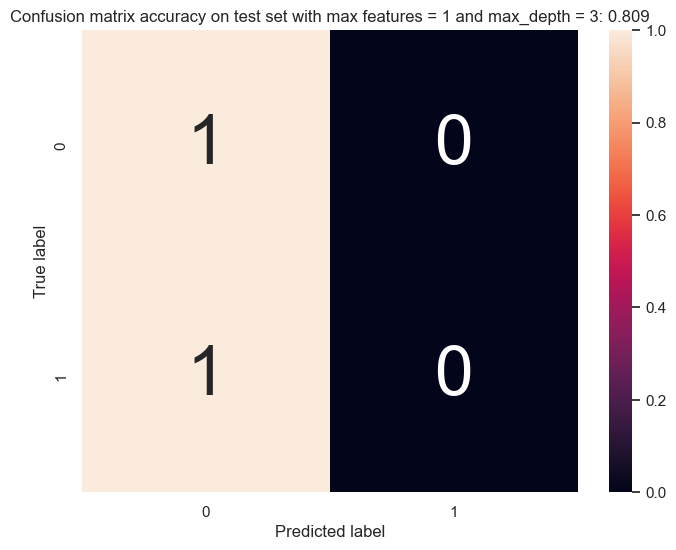

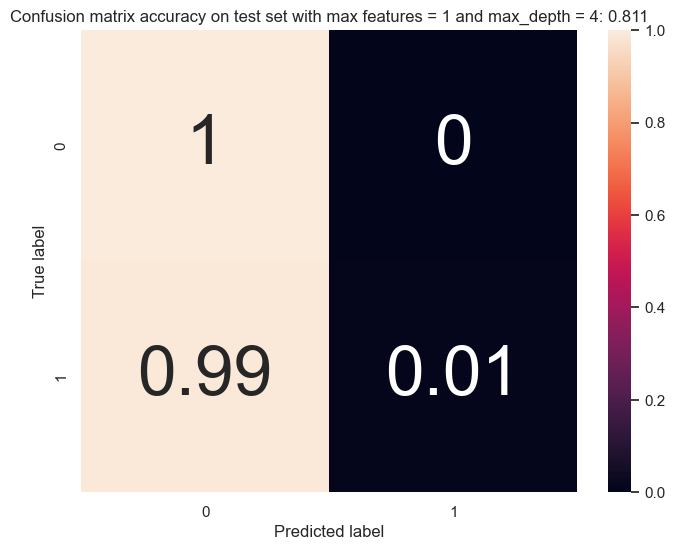

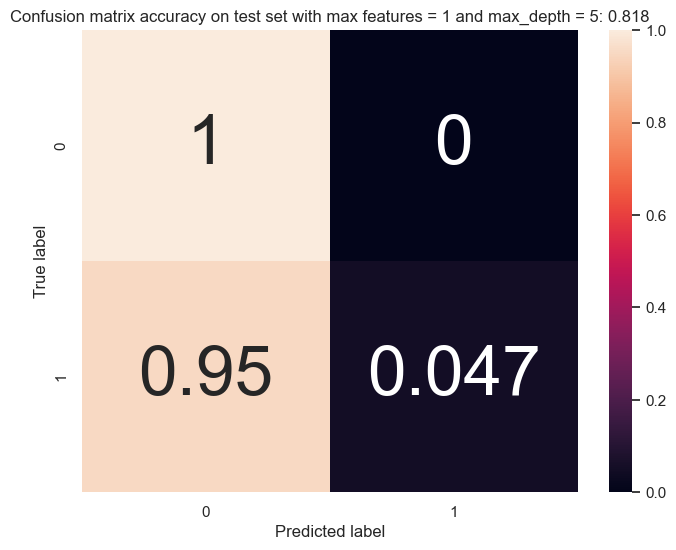

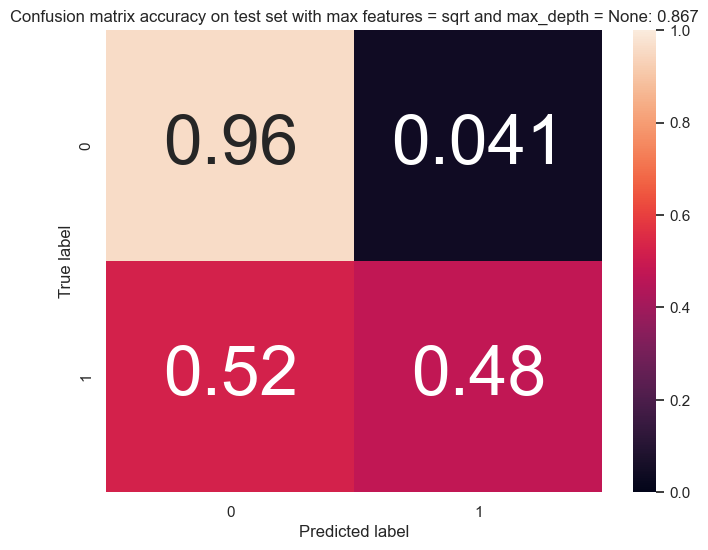

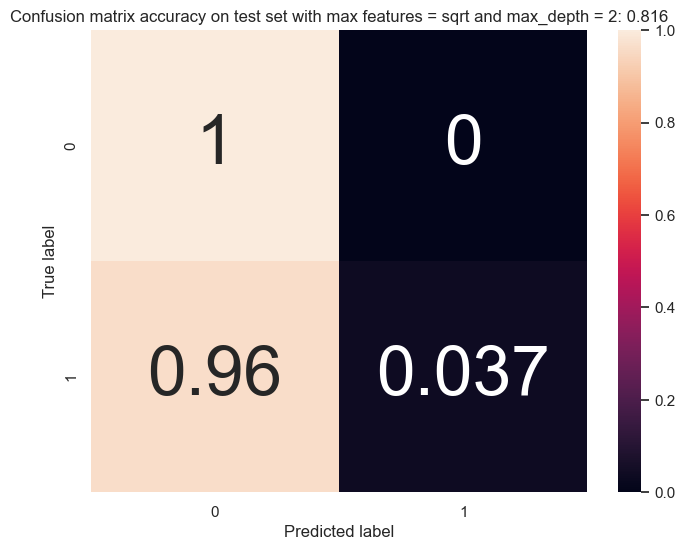

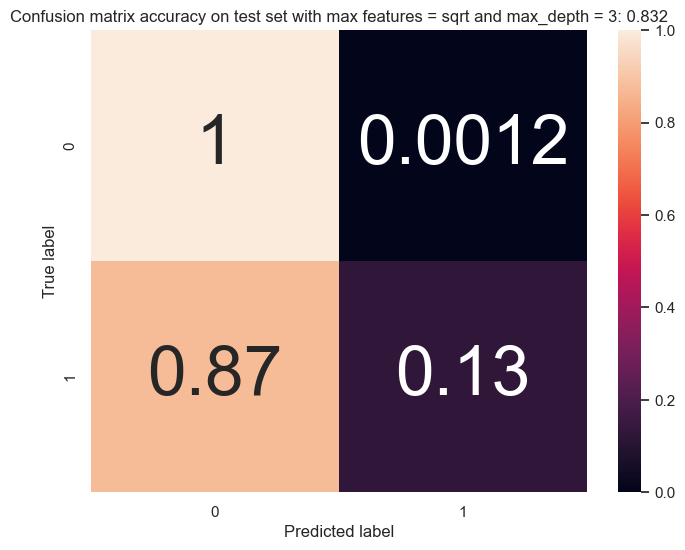

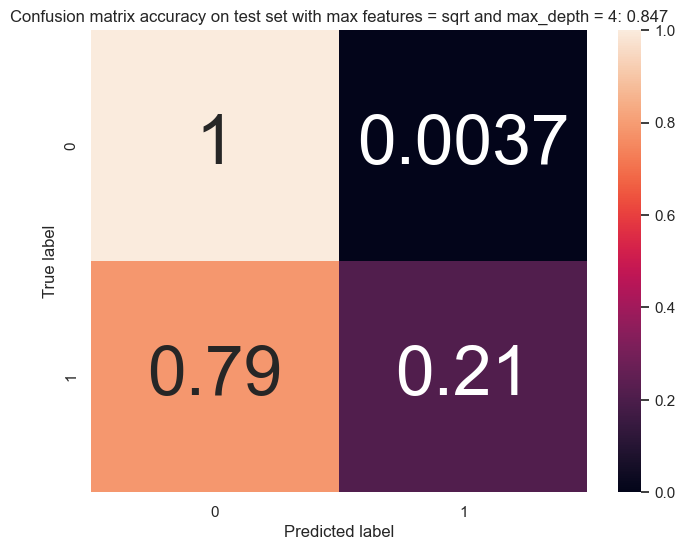

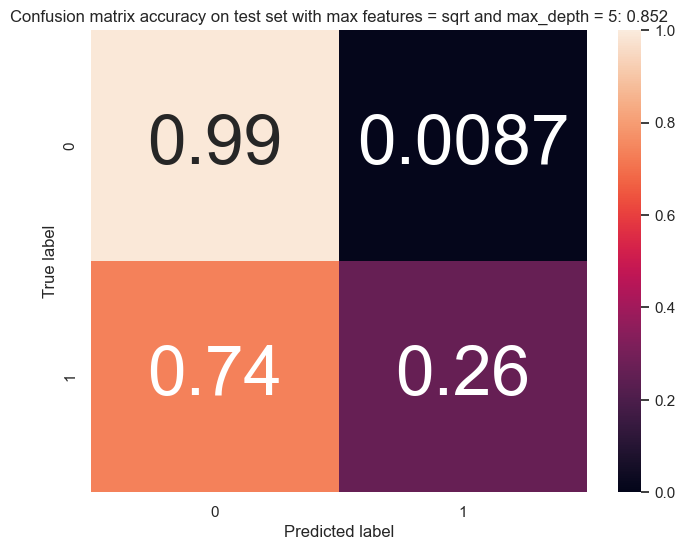

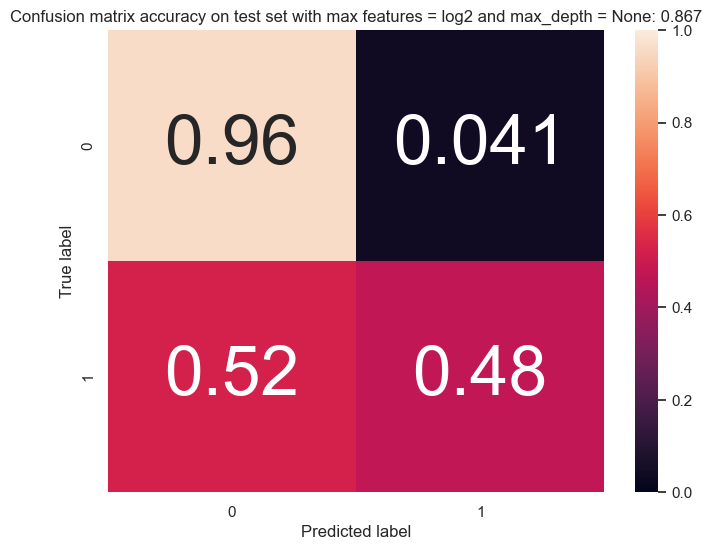

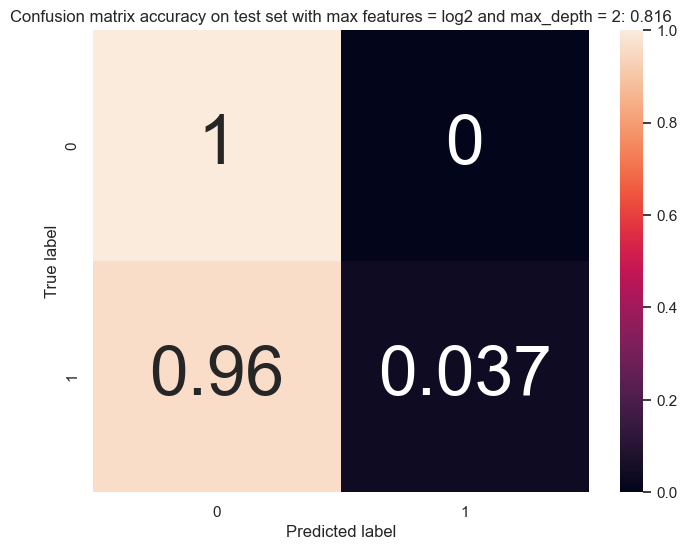

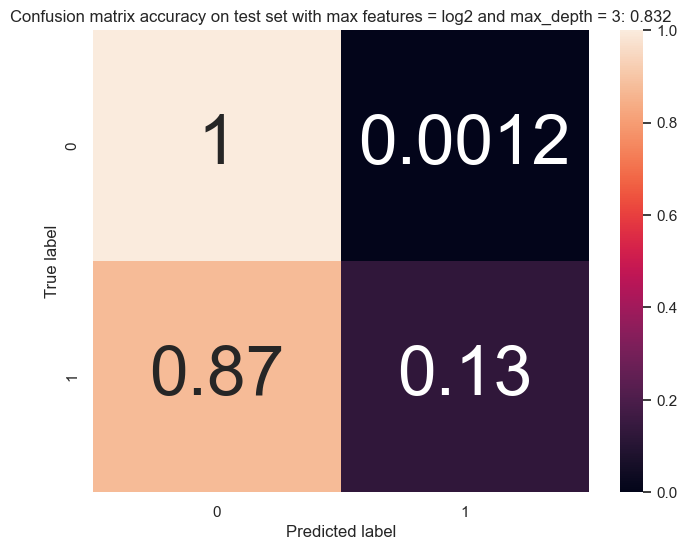

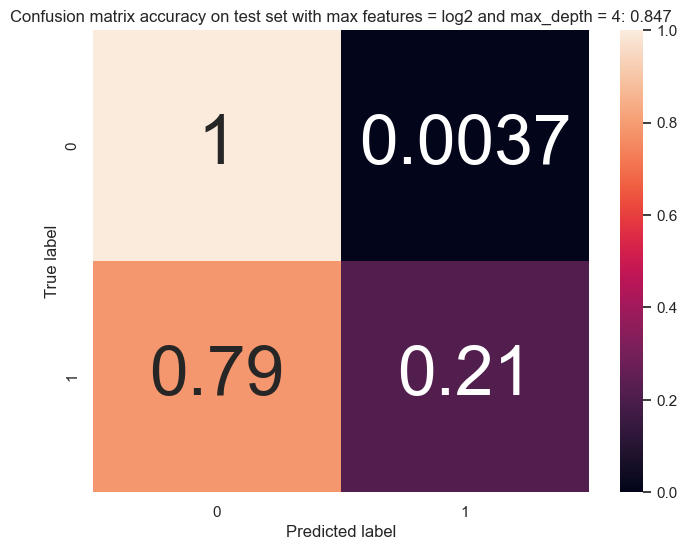

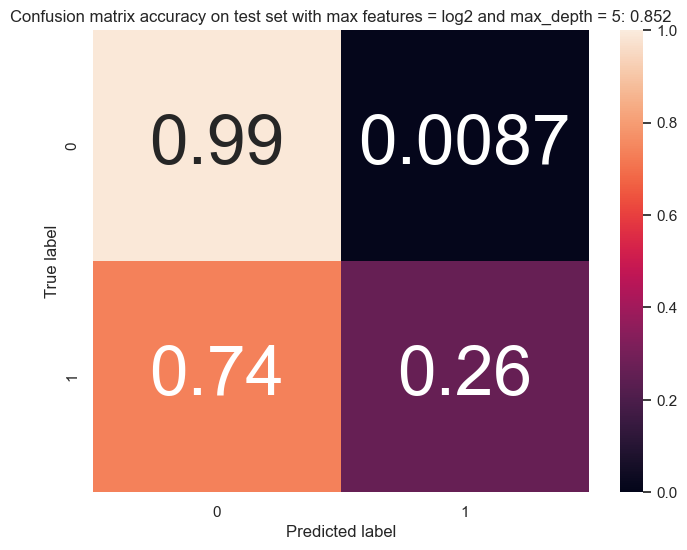

In [22]:
from itertools import product

n_estimators = 100
max_featuers = [ 1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]

for f, d in product(max_featuers, max_depths):
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                criterion="entropy",
                                max_features=f, 
                                max_depth=d,
                                n_jobs=2, 
                                random_state=123)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X = X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))


In [23]:
# Xgboost
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

classifier = xgb.XGBClassifier(tree_method = 'gpu_hist')

params = {
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]
}

clf = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring='roc_auc', cv=5, verbose=3)

clf.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.852 total time=   1.8s
[CV 2/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.860 total time=   0.2s
[CV 3/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.856 total time=   0.2s
[CV 4/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.860 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.845 total time=   0.2s
[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=1;, score=0.862 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=1;, score=0.863 total time=   0.1s
[CV 3/5] END colsample_bytre

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [24]:
clf.best_params_

{'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

In [25]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
print(y.shape)

(10000,)


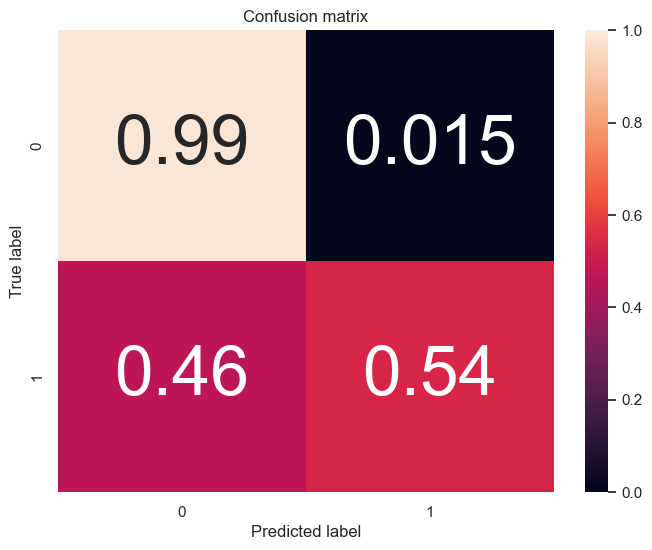

In [32]:
final_model = clf.best_estimator_

final_model.fit(X, y)

pred_xgboost = final_model.predict(X)


# confusion_matrix
cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

In [33]:
# Predicting Unseen data

unseen_data = pd.read_csv('unseen_data.csv')
unseen_data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [36]:
# limiting the data, applying same preprocessing steps that was used before in model developement

limited_unseen_data = unseen_data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

unseen_data2 = pd.get_dummies(limited_unseen_data, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])

scale_vars = ['CreditScore', 'EstimatedSalary', 'Balance', 'Age']
unseen_data2[scale_vars] = scaler.fit_transform(unseen_data2[scale_vars])

unseen_data2.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.342857,2,0.000000,1,0.507077,True,False,False,True,False,False,True,False,True
1,0.516,0.328571,1,0.334031,1,0.563089,False,False,True,True,False,True,False,False,True
2,0.304,0.342857,8,0.636357,3,0.570039,True,False,False,True,False,False,True,True,False
3,0.698,0.300000,1,0.000000,2,0.469437,True,False,False,True,False,True,False,True,False
4,1.000,0.357143,2,0.500246,1,0.395667,False,False,True,True,False,False,True,False,True


In [37]:
pred_xgboost = final_model.predict(unseen_data2.values)
pred_prob_xgboost = final_model.predict_proba(unseen_data2.values)

pred_xgboost

array([0, 0, 1, ..., 0, 0, 0])

In [38]:
pred_prob_xgboost

array([[0.644413, 0.355587],
       [0.712105, 0.287895],
       [0.126858, 0.873142],
       ...,
       [0.876297, 0.123703],
       [0.785754, 0.214246],
       [0.867410, 0.132590]], dtype=float32)

In [40]:
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

[np.float32(0.35558695),
 np.float32(0.28789485),
 np.float32(0.8731418),
 np.float32(0.09438321),
 np.float32(0.10227835),
 np.float32(0.2145295),
 np.float32(0.059283685),
 np.float32(0.9373156),
 np.float32(0.065647304),
 np.float32(0.058349274),
 np.float32(0.037741154),
 np.float32(0.032484133),
 np.float32(0.059558447),
 np.float32(0.050296206),
 np.float32(0.03995496),
 np.float32(0.13207722),
 np.float32(0.8916472),
 np.float32(0.036158264),
 np.float32(0.41025838),
 np.float32(0.03451808),
 np.float32(0.02927649),
 np.float32(0.059328824),
 np.float32(0.40976053),
 np.float32(0.09387783),
 np.float32(0.15672773),
 np.float32(0.021109859),
 np.float32(0.16778272),
 np.float32(0.07365871),
 np.float32(0.33482894),
 np.float32(0.107612856),
 np.float32(0.6803336),
 np.float32(0.089422494),
 np.float32(0.3187318),
 np.float32(0.07454864),
 np.float32(0.042749763),
 np.float32(0.5828318),
 np.float32(0.066389546),
 np.float32(0.05146366),
 np.float32(0.07083967),
 np.float32(0.0612

In [41]:
output = unseen_data.copy()
output['Predictions - Churn or Not'] = pred_xgboost
output['Predictions - Probability to Churn'] = column(pred_prob_xgboost, 1)
output['Predictions - Churn or Not Desc'] = 'Empty'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 0] = 'Retention'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 1] = 'Churn'
output.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Predictions - Churn or Not,Predictions - Probability to Churn,Predictions - Churn or Not Desc
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0.355587,Retention
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0.287895,Retention
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.873142,Churn
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.094383,Retention
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0.102278,Retention


In [42]:
# exporting the data to a csv file

output.to_csv('Churn_prediction_output.csv', index=False)


In [61]:
# count the number of churned customers and retained customers

reten, churn = output['Predictions - Churn or Not Desc'].value_counts()

# churned customers
print("The number of churned customers is: {} and the rate is {:.3f}%".format(churn, (churn / (churn + reten) * 100)))

# retained customers
print("The number of retained customers is : {} and the rate is {:.3f}%".format(reten, (reten / (churn + reten) * 100)))

The number of churned customers is: 429 and the rate is 12.829%
The number of retained customers is : 2915 and the rate is 87.171%


In [62]:
# saving the model

import joblib
joblib.dump(final_model, 'final_model.pkl')

# loading the model
# loaded_model = joblib.load('final_model.pkl')


['final_model.pkl']